# Uncalibrated Model Setup

In this notebook, we will:

1. Write each field's soil and irrigation infomation into a study-wide properties file.
2. Process the Landsat data and run a simple analysis of per-field NDVI dynamics that will provide some information on likely subseasonal irrigation application dates, harvest, and fallowing.
3. Join our Earth Engine extracts and meteorology data into a per-field time series.
4. Finally, write a per-field model input file that has all of the data needed.

Step 3 depends on a successful run of Step 2, and Step 4 depends on Step 3, so ensure the code runs to completion on each before moving on.

Note: For this tutorial, we're just putting data into each respective step's directory. This gets messy but is worth it to learn about the workflow in our first project. In the subsequent tutorial, we will standardize the directory structure for the calibration project and use a configuration file to specify all directories, model metadata, date range for the study period, etc. This will simplify our lives by hiding a lot of what we do in that tutorial under the hood of our SWIM car, so we can focus on calibration.

In [1]:
import os
import sys
import json

import numpy as np
import pandas as pd
import geopandas as gpd

# append the project path to the environment
root = '/home/dgketchum/PycharmProjects/swim-rs'
sys.path.append(root)

## 1. Write the soils and irrigation properties to a study-wide file.

We specify the inputs we've alread built and the ouput `json` file.

In [2]:
# Step-specific imports
from prep.field_properties import write_field_properties
from prep.field_timeseries import join_daily_timeseries

In [ ]:
# input properties files
irr = os.path.join(root, 'tutorial/step_2_earth_engine_extract/properties/tutorial_irr.csv')
ssurgo = os.path.join(root, 'tutorial/step_2_earth_engine_extract/properties/tutorial_ssurgo.csv')

# joined properties file
properties_json = os.path.join(root, 'tutorial/step_4_model_data_prep/tutorial_properties.json')

# the original study area shapefile
shapefile_path = os.path.join(root, 'tutorial/step_1_domain/mt_sid_boulder.shp')

In [ ]:
write_field_properties(shp=shapefile_path, irr=irr, ssurgo=ssurgo, js=properties_json, index_col='FID_1', shp_add=None,
                       targets=None)

We can check out the `properties_json` file to see what it's extracted. Let's see field '043_000160':

In [46]:
with open(properties_json, 'r') as f:
    properties_dict = json.load(f)
properties_dict['043_000160']

{'irr': {'1987': 0.3272132460942714,
  '1988': 0.3261867405528106,
  '1989': 0.3197272666577646,
  '1990': 0.2962261316597675,
  '1991': 0.2411620376552275,
  '1992': 0.1891357324075309,
  '1993': 0.560939377754039,
  '1994': 0.4646147683268792,
  '1995': 0.5454917211910799,
  '1996': 0.4849696221124313,
  '1997': 0.6506626385365201,
  '1998': 0.5828631993590598,
  '1999': 0.6616036854052609,
  '2000': 0.4539741621044196,
  '2001': 0.493482107090399,
  '2002': 0.4880241020162903,
  '2003': 0.5302443583923084,
  '2004': 0.5211476832687939,
  '2005': 0.5828631993590597,
  '2006': 0.5147633195353182,
  '2007': 0.4667428895713711,
  '2008': 0.4412054346374681,
  '2009': 0.5190195620243021,
  '2010': 0.94794865803178,
  '2011': 0.9835675657631192,
  '2012': 0.9699142075043398,
  '2013': 0.9832838162638536,
  '2014': 0.9896848711443452,
  '2015': 0.9878655361196425,
  '2016': 0.9896848711443452,
  '2017': 0.982340766457471,
  '2018': 0.9896848711443452,
  '2019': 0.9930397916944852,
  '2020'

This shows the fraction of the field that was irrigated each year since 1987, the soil hydraulic parameters AWC and Ksat, the soil texture information for clay and sand (loam = 100 - clay - sand), and the area of the field in square meters. 

Let's plot the study area irrigation information for 2004 to see the variation in fractional field irrigation coverage.

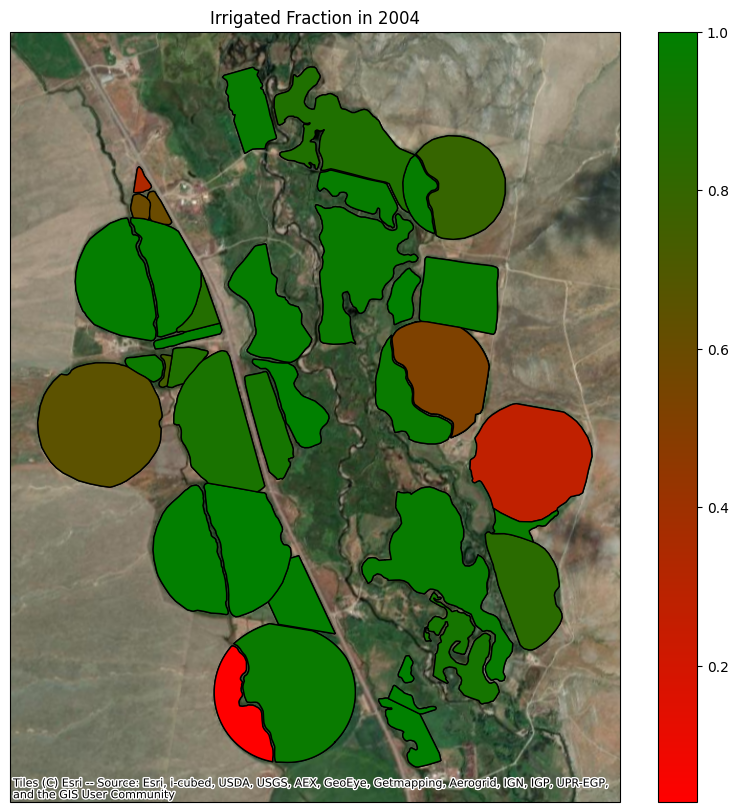

In [50]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import contextily as ctx
import cartopy.crs as ccrs
import random

# The following code raises a UserWarning that doesn't affect us, so we suppress it
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.") 

gdf = gpd.read_file(shapefile_path)
gdf.index = gdf['FID_1']

gdf['irr_2004'] = [properties_dict[i]['irr']['2004'] for i in gdf.index]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.epsg(5071)})

cmap = mcolors.LinearSegmentedColormap.from_list("rg", ["r", "g"])

gdf.plot(ax=ax, 
        edgecolor='black', 
        column='irr_2004',
        cmap=cmap,
        legend=True,
        transform=ccrs.epsg(5071))

ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs=ccrs.epsg(5071))

plt.title('Irrigated Fraction in 2004')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## 2. Process the Landsat (ETf and NDVI) data and run the agricultural dynamics analysis

We will run the code to interpolate and join the remote sensing-based data into per-field files first. This interpolates between capture-date NDVI, and marks the capture dates for later use in the calibration step.

We will send the extracted data to Step 2's landsat folder to reduce clutter.

Note: We use `clustered_landsat_time_series` for our data, because we used `clustered_sample_etf` and `clustered_sample_ndvi` when we did the extract. As mentioned when we ran the extraction code in Step 2, there are options for the 'sparse' and 'image'-based extraction; in the module `prep.landsat_sensing`, you will find their analogs for time series processing, i.e., `sparse_landsat_time_series` and `landsat_time_series_image`.

In [4]:
# Step-specific imports
from prep.landsat_sensing import clustered_landsat_time_series, join_remote_sensing, detecta_cuttings

In [7]:
# First, we build some tables that interpolate the capture-date data from the extract data we already downloaded:
tutorial_dir = os.path.join(root, 'tutorial')
landsat = os.path.join(tutorial_dir, 'step_2_earth_engine_extract' , 'landsat')
tables = os.path.join(landsat, 'tables')
if not os.path.isdir(tables):
    os.mkdir(tables)
    
extracts = os.path.join(landsat, 'extracts')

types_ = ['inv_irr', 'irr']
sensing_params = ['ndvi', 'etf']

for mask_type in types_:

    for sensing_param in sensing_params:
        
        yrs = [x for x in range(2004, 2024)]

        ee_data, src = None, None

        ee_data = os.path.join(extracts, sensing_param, mask_type)
        src = os.path.join(tables, '{}_{}_{}.csv'.format('tutorial', sensing_param, mask_type))
        src_ct = os.path.join(tables, '{}_{}_{}_ct.csv'.format('tutorial', sensing_param, mask_type))

        clustered_landsat_time_series(shapefile_path, ee_data, yrs, src, src_ct, feature_id='FID_1')


/home/dgketchum/PycharmProjects/swim-rs/tutorial/step_2_earth_engine_extract/landsat/extracts/ndvi/inv_irr


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 26.65it/s]


/home/dgketchum/PycharmProjects/swim-rs/tutorial/step_2_earth_engine_extract/landsat/extracts/etf/inv_irr


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 29.45it/s]


/home/dgketchum/PycharmProjects/swim-rs/tutorial/step_2_earth_engine_extract/landsat/extracts/ndvi/irr


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 26.84it/s]


/home/dgketchum/PycharmProjects/swim-rs/tutorial/step_2_earth_engine_extract/landsat/extracts/etf/irr


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 29.76it/s]


Next, join the daily remote sensing data to a single file, this will be a single, large file to hold all the NDVI and ETf data. 

In [9]:
remote_sensing_file = os.path.join(landsat, 'remote_sensing.csv')
join_remote_sensing(tables, remote_sensing_file)

etf_inv_irr_ct
ndvi_inv_irr_ct
etf_inv_irr
etf_irr
etf_irr_ct
ndvi_inv_irr
ndvi_irr_ct
ndvi_irr


In [20]:
# Let's take a look at the data for a single field
df = pd.read_csv(remote_sensing_file, index_col=0)
cols = [c for c in df.columns if '043_000128' in c]
df = df[cols]
print(df.head())
print(df.columns)

            043_000128_ndvi_irr  043_000128_ndvi_irr_ct  \
2004-01-01             0.249054                       0   
2004-01-02             0.249054                       0   
2004-01-03             0.249054                       0   
2004-01-04             0.249054                       0   
2004-01-05             0.249054                       0   

            043_000128_ndvi_inv_irr  043_000128_etf_irr_ct  \
2004-01-01                 0.201087                      0   
2004-01-02                 0.201087                      0   
2004-01-03                 0.201087                      0   
2004-01-04                 0.201087                      0   
2004-01-05                 0.201087                      0   

            043_000128_etf_irr  043_000128_etf_inv_irr  \
2004-01-01            0.281106                0.215817   
2004-01-02            0.281106                0.215817   
2004-01-03            0.281106                0.215817   
2004-01-04            0.281106          

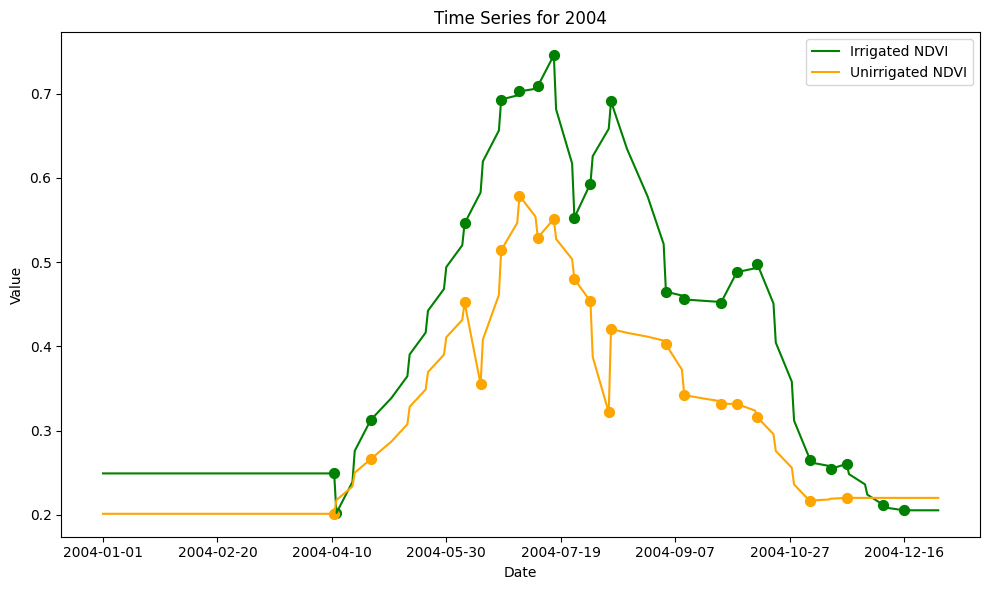

In [38]:
# And plot it, first NDVI
import matplotlib.pyplot as plt
import pandas as pd

columns_to_plot = [('043_000128_ndvi_irr', 'Irrigated NDVI', 'green'),
                   ('043_000128_ndvi_inv_irr', 'Unirrigated NDVI', 'orange')]

fig, ax = plt.subplots(figsize=(10, 6))

df_year = df.loc['2004-01-01': '2004-12-31'].copy()

for column, desc, color in columns_to_plot:
    df_year[column].plot(ax=ax, label=desc, color=color)

    ct_column = column + '_ct'
    scatter_data = df_year[column].copy()
    scatter_data[df_year[ct_column] == 0] = np.nan
    ax.scatter(scatter_data.index, scatter_data, marker='o', s=50, c=color)

ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Time Series for 2004')
ax.legend()

plt.tight_layout()
plt.show()

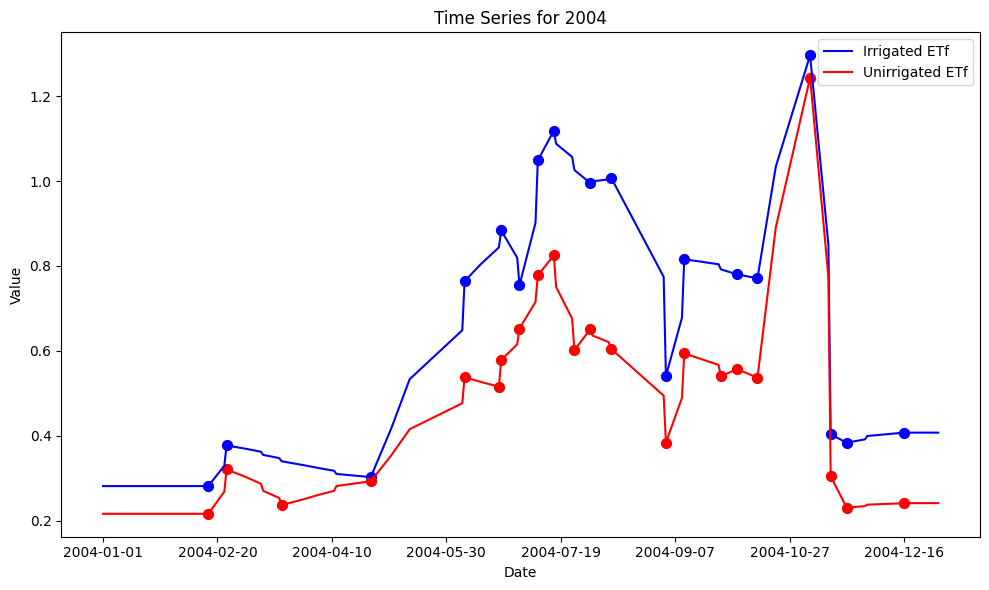

In [39]:
import matplotlib.pyplot as plt
import pandas as pd

columns_to_plot = [('043_000128_etf_irr', 'Irrigated ETf', 'blue'),
                   ('043_000128_etf_inv_irr', 'Unirrigated ETf', 'red')]

fig, ax = plt.subplots(figsize=(10, 6))

df_year = df.loc['2004-01-01': '2004-12-31'].copy()

for column, desc, color in columns_to_plot:
    df_year[column].plot(ax=ax, label=desc, color=color)

    ct_column = column + '_ct'
    scatter_data = df_year[column].copy()
    scatter_data[df_year[ct_column] == 0] = np.nan
    ax.scatter(scatter_data.index, scatter_data, marker='o', s=50, c=color)

ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Time Series for 2004')
ax.legend()

plt.tight_layout()
plt.show()

Finally, we use both the irrigation and NDVI data to run an analysis to infer simple agricultural information and get an estimate of the dates of greenup, harvest, irrigation, etc. We choose a low irrigation threshold, below which the irrigation data will not be analyzed and the field will be assumed unirrigated. Let's choose 10% for now.

In [ ]:
cuttings_json = os.path.join(landsat, 'tutorial_cuttings.json'.format(project))
detecta_cuttings(remote_sensing_file, irr, irr_threshold=0.1, out_json=cuttings_json)

## 3. Join the Earth Engine and meteorology time series.

We now specify the inputs we're going to use for our time series, which will have irrigated and unirrigated ETf and NDVI, and all the meteorology data we pulled from GridMET and NLDAS-2. We will need the shapefile we built that has the associated GridMET 'GFID' attribute added:

In [ ]:
fields_gridmet = os.path.join(root, 'tutorial', 'step_3_meteorology_extract', 'mt_sid_boulder_gfid.shp')
met = os.path.join(root, 'tutorial', 'step_3_meteorology_extract', 'met_timeseries')
landsat = os.path.join(root, 'tutorial/step_2_earth_engine_extract/landsat')
snow = os.path.join(root, 'tutorial/step_2_earth_engine_extract/snodas/snodas.json')

joined_timeseries = os.path.join(root, 'tutorial/step_4_model_data_prep/input_timeseries')
if not os.path.isdir(joined_timeseries):
    os.mkdir(joined_timeseries)

Since we may have unirrigated and irrigated fields, we specify processing of both mask types for both remote sensing sources: 'irr' and 'inv_irr'.

In [27]:
params = ['etf_inv_irr',
          'ndvi_inv_irr',
          'etf_irr',
          'ndvi_irr']

join_daily_timeseries(fields=fields_gridmet,
                      gridmet_dir=met,
                      landsat_table=landsat,
                      snow=snow,
                      dst_dir=joined_timeseries,
                      overwrite=False,
                      start_date='2004-01-01',
                      end_date='2023-12-31', 
                      **{'params': params})

IsADirectoryError: [Errno 21] Is a directory: '/home/dgketchum/PycharmProjects/swim-rs/tutorial/step_2_earth_engine_extract/landsat'